In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/likelion/project1/

Mounted at /gdrive
/gdrive/MyDrive/likelion/project1


In [3]:
import os
import random
import ast
from typing import List, Dict
import io
import tarfile

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, Wav2Vec2Model, AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================================
# 1. 환경 설정 및 랜덤 시드 고정
# =========================================
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 10
TEXT_MODEL_NAME = "beomi/KcELECTRA-base"
TRAIN_CSV_PATH = "./data/training/train.csv"
TRAIN_AUDIO_TAR = "./data/training/train_audio.tar"
VALID_CSV_PATH = "./data/validation/valid.csv"
VALID_AUDIO_TAR = "./data/validation/total/valid_audio.tar"
MAX_TEXT_LEN = 128
SAMPLE_RATE = 16000
MAX_AUDIO_FRAMES = 400
MIN_AUDIO_FRAMES = 8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

# =========================================
# 2. 텍스트 전처리 함수
# =========================================
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)

def preprocess_text(text: str, tokenizer, max_length: int = MAX_TEXT_LEN) -> Dict[str, torch.Tensor]:
    if isinstance(text, str) and len(text.strip()) > 0:
        sentences = [s.strip().strip('"') for s in text.split(',') if s.strip()]
    else:
        sentences = []
    joined_text = ' [SEP] '.join(sentences) if sentences else ''
    enc = tokenizer(
        joined_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    return {k: v.squeeze(0) for k, v in enc.items()}

# =========================================
# 3. wav2vec2-XLSR 모델 초기화
# =========================================
# wav2vec2-XLSR 모델 초기화
W2V_MODEL_NAME = "facebook/wav2vec2-xls-r-300m"  # 멀티링구얼 모델 (한국어 포함)
w2v_fe = AutoFeatureExtractor.from_pretrained(W2V_MODEL_NAME)
w2v_model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME).to(device)
# w2v_model = Wav2Vec2Model.from_pretrained(
#     W2V_MODEL_NAME,
#     use_safetensors=True,   # safetensors 우선
#     cache_dir="./hf_cache"  # (선택) 캐시 위치 고정
# ).to(device)
w2v_model.eval()

# 여기!
for p in w2v_model.parameters():
    p.requires_grad = False

# 샘플링 레이트
SAMPLE_RATE = 16000
MIN_AUDIO_FRAMES = 8
MAX_AUDIO_FRAMES = 400

# =========================================
# 4. Dataset 정의
# =========================================
class TextAudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, meta_cols: List[str], audio_tar_path: str,
                 urgency_map: Dict[str, float], sentiment_map: Dict[str, int]):
        self.df = df.reset_index(drop=True)
        self.meta_cols = meta_cols
        self.audio_tar_path = audio_tar_path
        self.urgency_map = urgency_map
        self.sentiment_map = sentiment_map

        # 메타데이터 인덱스 매핑
        self.meta_maps = {}
        self.meta_vocab_sizes = {}
        for col in meta_cols:
            uniques = list(df[col].dropna().unique())
            self.meta_maps[col] = {v: (i + 1) for i, v in enumerate(uniques)}
            self.meta_vocab_sizes[col] = len(uniques) + 1

        # 오디오 로딩 (tar 내부)
        self.audio_data = {}
        if audio_tar_path and os.path.exists(audio_tar_path):
            mode = 'r:gz' if audio_tar_path.endswith(('.tar.gz', '.tgz')) else 'r'
            with tarfile.open(audio_tar_path, mode) as tar:
                for member in tar.getmembers():
                    if member.isfile():
                        f = tar.extractfile(member)
                        if f:
                            self.audio_data[os.path.basename(member.name)] = f.read()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # -----------------------------
        # 1) 텍스트 처리
        # -----------------------------
        text_enc = preprocess_text(row.get('text', ''), tokenizer, MAX_TEXT_LEN)

        # -----------------------------
        # 2) wav2vec2-XLSR 오디오 처리
        # -----------------------------
        audio_paths = []
        if 'audio_split_list' in row and pd.notna(row['audio_split_list']):
            try:
                audio_paths = ast.literal_eval(row['audio_split_list'])
                if not isinstance(audio_paths, (list, tuple)):
                    audio_paths = []
            except Exception:
                audio_paths = []

        features = []
        for audio_file in audio_paths:
            audio_bytes = self.audio_data.get(audio_file)
            if audio_bytes is None:
                features.append(None)
                continue
            try:
                waveform, sr = torchaudio.load(io.BytesIO(audio_bytes))  # (ch, T)
            except Exception:
                features.append(None)
                continue

            # mono + 16k
            if waveform.dim() == 2 and waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            with torch.no_grad():
                fe_out = w2v_fe(
                    waveform.squeeze(0).numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
                )
                input_values = fe_out.input_values.to(device)  # (1, T')
                out = w2v_model(input_values)                  # (1, t, d)
                hs = out.last_hidden_state.squeeze(0)          # (t, d)
                hs = hs.transpose(0, 1).contiguous()           # (d, t)

                # 프레임 패딩/자르기 (기존 하이퍼 재사용)
                frames = hs.size(1)
                if frames < MAX_AUDIO_FRAMES:
                    hs = torch.nn.functional.pad(hs, (0, MAX_AUDIO_FRAMES - frames))  # ← 무조건 MAX에 맞추기
                else:
                    hs = hs[:, :MAX_AUDIO_FRAMES]
                features.append(hs)

        # 여러 조각 평균, 없으면 0-텐서
        D = w2v_model.config.hidden_size  # 예: 1024(300m)
        if len(features) == 0:
            audio_feat = torch.zeros(D, MAX_AUDIO_FRAMES, device=device)
        else:
            # 조각들 길이 확인
            lengths = [f.size(1) for f in features if f is not None]
            target_T = MIN_AUDIO_FRAMES if len(lengths) == 0 else min(MAX_AUDIO_FRAMES, max(lengths))

            fixed = []
            for f in features:
                if f is None:
                    fixed.append(torch.zeros(D, target_T, device=device))
                    continue
                t = f.size(1)
                if t < target_T:
                    f = torch.nn.functional.pad(f, (0, target_T - t))
                elif t > target_T:
                    f = f[:, :target_T]
                fixed.append(f)

            audio_feat = torch.stack(fixed, dim=0).mean(dim=0)  # (D, target_T)

        # -----------------------------
        # 3) 메타데이터 처리
        # -----------------------------
        meta_idx = []
        for col in self.meta_cols:
            val = row.get(col, None)
            idx_val = 0 if pd.isna(val) or val is None else self.meta_maps.get(col, {}).get(val, 0)
            vocab_size = self.meta_vocab_sizes.get(col, 1)
            idx_val = max(0, min(idx_val, vocab_size-1))
            meta_idx.append(idx_val)
        meta_idx = torch.tensor(meta_idx, dtype=torch.long) if meta_idx else torch.tensor([0], dtype=torch.long)

        # -----------------------------
        # 4) Labels 처리
        # -----------------------------
        urg_val = row.get('urgencyLevel', None)
        urgency = self.urgency_map.get(urg_val, self.urgency_map.get(str(urg_val), 0.0))
        try:
            urgency = float(urgency)
        except Exception:
            urgency = 0.0
        urgency = torch.tensor(urgency, dtype=torch.float)

        sent_val = row.get('sentiment', None)
        sentiment_idx = self.sentiment_map.get(sent_val, self.sentiment_map.get(str(sent_val), 0))
        num_classes = max(1, len(self.sentiment_map))
        sentiment_idx = max(0, min(sentiment_idx, num_classes-1))
        sentiment = torch.tensor(sentiment_idx, dtype=torch.long)

        return {
            'input_ids': text_enc['input_ids'].to(device),
            'attention_mask': text_enc['attention_mask'].to(device),
            'audio_feat': audio_feat.to(device),
            'meta_idx': meta_idx.to(device),
            'urgency': urgency.to(device),
            'sentiment': sentiment.to(device)
        }

# =========================================
# 3-1. collate_fn: dynamic padding
# =========================================
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    meta_idx = torch.stack([item['meta_idx'] for item in batch])
    urgency = torch.stack([item['urgency'] for item in batch])
    sentiment = torch.stack([item['sentiment'] for item in batch])

    audio_feats = [item['audio_feat'] for item in batch]
    max_frames = max([feat.size(1) for feat in audio_feats])
    padded_audio = [torch.nn.functional.pad(feat, (0, max_frames - feat.size(1))) for feat in audio_feats]
    audio_feat = torch.stack(padded_audio)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'audio_feat': audio_feat,
        'meta_idx': meta_idx,
        'urgency': urgency,
        'sentiment': sentiment
    }

# =========================================
# 4. 모델 정의 (wav2vec2-XLSR용)
# =========================================
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_name, meta_maps: Dict[str, Dict],
                 audio_emb_dim=256, joint_dim=256, num_classes_sentiment=4,
                 audio_input_dim=None):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, joint_dim)

        if audio_input_dim is None:
            audio_input_dim = w2v_model.config.hidden_size

        self.audio_proj_shared = nn.Linear(audio_input_dim, audio_emb_dim)
        self.audio_proj_urgency = nn.Linear(audio_emb_dim, joint_dim)
        self.audio_proj_sentiment = nn.Linear(audio_emb_dim, joint_dim)

        # --- Meta Embeddings ---
        self.meta_embs = nn.ModuleDict()
        for k, mapping in meta_maps.items():
            num_embeddings = len(mapping) + 1
            emb_dim = min(8, num_embeddings)
            self.meta_embs[k] = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=emb_dim, padding_idx=0)
        self.meta_out_dim = sum([emb.embedding_dim for emb in self.meta_embs.values()]) if self.meta_embs else 0

        # --- 최종 Fusion MLP (text + audio + meta) ---
        self.fusion_dim = joint_dim * 2 + self.meta_out_dim
        self.fusion_mlp_urgency = nn.Sequential(
            nn.Linear(self.fusion_dim, joint_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fusion_mlp_sentiment = nn.Sequential(
            nn.Linear(self.fusion_dim, joint_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # --- Output Heads ---
        self.urgency_head = nn.Linear(joint_dim, 1)
        self.sentiment_head = nn.Linear(joint_dim, num_classes_sentiment)

    def forward(self, input_ids, attention_mask, audio_feat, meta_idx):
        B = input_ids.size(0)
        # --- Text Encoder ---
        txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        txt_emb = self.text_proj(txt_out.last_hidden_state[:, 0, :])

        # --- Audio Encoder ---
        audio_mean = audio_feat.mean(dim=2)  # (B, D)
        audio_emb = self.audio_proj_shared(audio_mean)
        audio_emb_urgency = self.audio_proj_urgency(audio_emb)
        audio_emb_sentiment = self.audio_proj_sentiment(audio_emb)

        # --- Meta Embedding ---
        if not self.meta_embs:
            meta_emb = torch.zeros(B, 0, device=input_ids.device)
        else:
            if meta_idx.dim() == 1:
                meta_idx = meta_idx.unsqueeze(0).expand(B, -1)
            meta_embeddings = [self.meta_embs[k](meta_idx[:, i].clamp(0, self.meta_embs[k].num_embeddings-1))
                               for i, k in enumerate(self.meta_embs.keys())]
            meta_emb = torch.cat(meta_embeddings, dim=1)

        # --- Fusion: concat text + audio + meta ---
        fusion_urgency = torch.cat([txt_emb, audio_emb_urgency, meta_emb], dim=1)
        fusion_sentiment = torch.cat([txt_emb, audio_emb_sentiment, meta_emb], dim=1)

        # --- Fusion MLP 통과 ---
        joint_urgency = self.fusion_mlp_urgency(fusion_urgency)
        joint_sentiment = self.fusion_mlp_sentiment(fusion_sentiment)

        # --- Output Heads ---
        urg_out = self.urgency_head(joint_urgency).squeeze(1)
        sent_out = self.sentiment_head(joint_sentiment)

        return urg_out, sent_out


# =========================================
# 5. 학습 함수
# =========================================
def train_model(df_train, df_valid, meta_cols, train_tar, valid_tar,
                urgency_map, sentiment_map,
                num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):

    meta_maps = {col: {v: (i + 1) for i, v in enumerate(df_train[col].dropna().unique())} for col in meta_cols}
    train_dataset = TextAudioDataset(df_train, meta_cols, train_tar, urgency_map, sentiment_map)
    valid_dataset = TextAudioDataset(df_valid, meta_cols, valid_tar, urgency_map, sentiment_map)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model = MultimodalClassifier(
        TEXT_MODEL_NAME, meta_maps,
        num_classes_sentiment=len(sentiment_map),
        audio_input_dim=w2v_model.config.hidden_size  # wav2vec2-XLSR의 hidden dim
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion_reg = nn.MSELoss()
    criterion_cls = nn.CrossEntropyLoss()

    train_losses, train_reg_losses, train_cls_losses = [], [], []
    valid_losses, valid_reg_losses, valid_cls_losses = [], [], []
    mse_list, mae_list, acc_list, f1_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_reg, total_train_cls = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                        batch['audio_feat'], batch['meta_idx'])
            reg_loss = criterion_reg(pred_urg, batch['urgency'])
            cls_loss = criterion_cls(pred_sent, batch['sentiment'])
            loss = reg_loss + cls_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_reg += reg_loss.item()
            total_train_cls += cls_loss.item()

        train_losses.append(total_train_loss / len(train_loader))
        train_reg_losses.append(total_train_reg / len(train_loader))
        train_cls_losses.append(total_train_cls / len(train_loader))

        model.eval()
        total_valid_loss, total_valid_reg, total_valid_cls = 0, 0, 0
        all_urg_pred, all_urg_true = [], []
        all_sent_pred, all_sent_true = [], []

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]"):
                pred_urg, pred_sent = model(batch['input_ids'], batch['attention_mask'],
                                            batch['audio_feat'], batch['meta_idx'])
                reg_loss = criterion_reg(pred_urg, batch['urgency'])
                cls_loss = criterion_cls(pred_sent, batch['sentiment'])
                loss = reg_loss + cls_loss

                total_valid_loss += loss.item()
                total_valid_reg += reg_loss.item()
                total_valid_cls += cls_loss.item()

                all_urg_pred.extend(pred_urg.cpu().numpy())
                all_urg_true.extend(batch['urgency'].cpu().numpy())
                all_sent_pred.extend(pred_sent.argmax(dim=1).cpu().numpy())
                all_sent_true.extend(batch['sentiment'].cpu().numpy())

        valid_losses.append(total_valid_loss / len(valid_loader))
        valid_reg_losses.append(total_valid_reg / len(valid_loader))
        valid_cls_losses.append(total_valid_cls / len(valid_loader))

        mse = mean_squared_error(all_urg_true, all_urg_pred)
        mae = mean_absolute_error(all_urg_true, all_urg_pred)
        acc = accuracy_score(all_sent_true, all_sent_pred)
        f1 = f1_score(all_sent_true, all_sent_pred, average='weighted')

        mse_list.append(mse)
        mae_list.append(mae)
        acc_list.append(acc)
        f1_list.append(f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Valid Loss: {valid_losses[-1]:.4f}")
        print(f"Train Reg Loss: {train_reg_losses[-1]:.4f} | Train Cls Loss: {train_cls_losses[-1]:.4f}")
        print(f"Valid Reg Loss: {valid_reg_losses[-1]:.4f} | Valid Cls Loss: {valid_cls_losses[-1]:.4f}")
        print(f"Regression -> MSE: {mse:.4f}, MAE: {mae:.4f}")
        print(f"Classification -> Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}\n")

    scores = {
        'train_loss': train_losses, 'train_reg_loss': train_reg_losses, 'train_cls_loss': train_cls_losses,
        'valid_loss': valid_losses, 'valid_reg_loss': valid_reg_losses, 'valid_cls_loss': valid_cls_losses,
        'mse': mse_list, 'mae': mae_list, 'accuracy': acc_list, 'f1': f1_list
    }
    return model, scores

# =========================================
# 6. 학습 결과 시각화
# =========================================
def plot_scores(scores):
    epochs = range(1, len(scores['train_loss'])+1)
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs, scores['train_reg_loss'], label='Train Reg Loss')
    plt.plot(epochs, scores['train_cls_loss'], label='Train Cls Loss')
    plt.plot(epochs, scores['valid_reg_loss'], '--', label='Valid Reg Loss')
    plt.plot(epochs, scores['valid_cls_loss'], '--', label='Valid Cls Loss')
    plt.title('Regression & Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, scores['mse'], label='MSE')
    plt.plot(epochs, scores['mae'], label='MAE')
    plt.plot(epochs, scores['accuracy'], label='Accuracy')
    plt.plot(epochs, scores['f1'], label='F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.show()

device : cuda


(500, 15)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 1/10
Train Loss: 1.9439 | Valid Loss: 1.5160
Train Reg Loss: 0.8271 | Train Cls Loss: 1.1168
Valid Reg Loss: 0.6082 | Valid Cls Loss: 0.9078
Regression -> MSE: 0.6162, MAE: 0.6694
Classification -> Accuracy: 0.5700, Weighted F1: 0.4139



Epoch 2 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 2/10
Train Loss: 1.4699 | Valid Loss: 1.4359
Train Reg Loss: 0.6130 | Train Cls Loss: 0.8569
Valid Reg Loss: 0.5861 | Valid Cls Loss: 0.8498
Regression -> MSE: 0.5907, MAE: 0.6296
Classification -> Accuracy: 0.5700, Weighted F1: 0.4139



Epoch 3 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 3/10
Train Loss: 1.3662 | Valid Loss: 1.5576
Train Reg Loss: 0.5349 | Train Cls Loss: 0.8312
Valid Reg Loss: 0.7025 | Valid Cls Loss: 0.8551
Regression -> MSE: 0.7300, MAE: 0.6928
Classification -> Accuracy: 0.5700, Weighted F1: 0.4139



Epoch 4 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 4/10
Train Loss: 1.2210 | Valid Loss: 1.3965
Train Reg Loss: 0.3939 | Train Cls Loss: 0.8271
Valid Reg Loss: 0.5448 | Valid Cls Loss: 0.8517
Regression -> MSE: 0.5600, MAE: 0.6124
Classification -> Accuracy: 0.5700, Weighted F1: 0.4309



Epoch 5 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 5/10
Train Loss: 1.0267 | Valid Loss: 1.5607
Train Reg Loss: 0.2333 | Train Cls Loss: 0.7935
Valid Reg Loss: 0.7093 | Valid Cls Loss: 0.8514
Regression -> MSE: 0.7246, MAE: 0.6844
Classification -> Accuracy: 0.5700, Weighted F1: 0.4595



Epoch 6 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 6/10
Train Loss: 0.8846 | Valid Loss: 1.5763
Train Reg Loss: 0.0991 | Train Cls Loss: 0.7855
Valid Reg Loss: 0.7242 | Valid Cls Loss: 0.8521
Regression -> MSE: 0.7518, MAE: 0.7043
Classification -> Accuracy: 0.5900, Weighted F1: 0.5152



Epoch 7 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 7/10
Train Loss: 0.8470 | Valid Loss: 1.5019
Train Reg Loss: 0.0753 | Train Cls Loss: 0.7717
Valid Reg Loss: 0.6615 | Valid Cls Loss: 0.8405
Regression -> MSE: 0.6999, MAE: 0.6912
Classification -> Accuracy: 0.6100, Weighted F1: 0.5597



Epoch 8 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 8/10
Train Loss: 0.8017 | Valid Loss: 1.4333
Train Reg Loss: 0.0599 | Train Cls Loss: 0.7418
Valid Reg Loss: 0.5844 | Valid Cls Loss: 0.8489
Regression -> MSE: 0.6156, MAE: 0.6553
Classification -> Accuracy: 0.6000, Weighted F1: 0.5579



Epoch 9 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytor


Epoch 9/10
Train Loss: 0.7389 | Valid Loss: 1.5165
Train Reg Loss: 0.0584 | Train Cls Loss: 0.6805
Valid Reg Loss: 0.6628 | Valid Cls Loss: 0.8537
Regression -> MSE: 0.7037, MAE: 0.6954
Classification -> Accuracy: 0.5900, Weighted F1: 0.5440



Epoch 10 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto


Epoch 10/10
Train Loss: 0.6576 | Valid Loss: 1.4706
Train Reg Loss: 0.0654 | Train Cls Loss: 0.5921
Valid Reg Loss: 0.6493 | Valid Cls Loss: 0.8213
Regression -> MSE: 0.6961, MAE: 0.6788
Classification -> Accuracy: 0.6400, Weighted F1: 0.6285



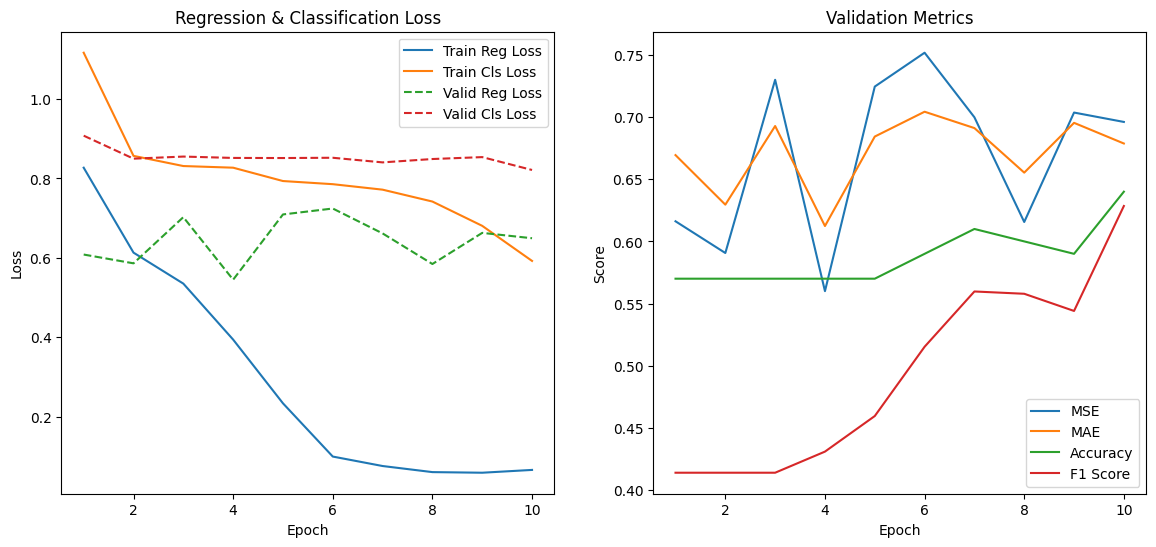

In [4]:
# =========================================
# 7. 학습 실행
# =========================================
df = pd.read_csv(TRAIN_CSV_PATH)

# [아람EDITED] - disasterLarge 비율 유지하여 약 500개로 다운샘플
LABEL_COL = "disasterLarge"  # 비율 기준 컬럼명
TARGET_N = 500               # 다운샘플 목표 개수
RS = SEED

if LABEL_COL in df.columns and len(df) > TARGET_N:
    # --- Stratified downsample (Largest Remainder Method) ---
    counts = df[LABEL_COL].value_counts(dropna=False)
    probs = counts / counts.sum()
    raw = probs * TARGET_N

    base = np.floor(raw).astype(int)                # 기본 할당
    leftover = int(TARGET_N - base.sum())           # 남은 몫
    # 가장 큰 소수점부터 1개씩 추가
    remainders = (raw - base).sort_values(ascending=False)

    alloc = base.copy()
    for lbl in remainders.index[:leftover]:
        alloc[lbl] += 1

    # 각 그룹에서 할당 수만큼 샘플 (그룹 실제 크기보다 큰 경우 cap)
    parts = []
    for lbl, n_take in alloc.items():
        grp = df[df[LABEL_COL] == lbl]
        n_final = min(len(grp), int(n_take))
        if n_final > 0:
            parts.append(grp.sample(n=n_final, random_state=RS))
    df = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RS).reset_index(drop=True)
print(df.shape)
# [아람EDITED]

meta_cols = [c for c in df.columns if c not in ['text','audio_split_list','urgencyLevel','sentiment']]

urgency_map = {'상': 2.0, '중': 1.0, '하': 0.0}
sentiment_map = {'불안/걱정':0, '당황/난처':1, '중립':2, '기타부정':3}

valid_size = int(len(df) * 0.2)
df_train = df.iloc[:-valid_size].reset_index(drop=True)
df_valid = df.iloc[-valid_size:].reset_index(drop=True)

# 모델 학습 및 평가
model, scores = train_model(df_train, df_valid, meta_cols,
                            TRAIN_AUDIO_TAR, VALID_AUDIO_TAR,
                            urgency_map, sentiment_map)

# 학습 결과 시각화
plot_scores(scores)

In [5]:
# =========================================
# 10. 테스트/추론
# =========================================
print("========================= 테스트 =========================")
VALID_CSV_PATH = "./data/validation/valid.csv"
VALID_AUDIO_TAR = "./data/validation/total/valid_audio.tar"

# 테스트 데이터 로드
df_test = pd.read_csv(VALID_CSV_PATH)

# 테스트용 Dataset 생성
test_dataset = TextAudioDataset(df_test, meta_cols, VALID_AUDIO_TAR, urgency_map, sentiment_map)

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 모델 평가 모드
model.eval()

# 결과 저장 리스트 초기화
preds_urgency, preds_sentiment = [], []
labels_urgency, labels_sentiment = [], []

# 테스트 루프
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        # GPU 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        audio_feat = batch['audio_feat'].to(device)
        meta_idx = batch['meta_idx'].to(device)
        label_urgency = batch['urgency'].to(device)
        label_sentiment = batch['sentiment'].to(device)

        # 예측
        pred_urg, pred_sent = model(input_ids, attention_mask, audio_feat, meta_idx)

        # 결과 저장
        preds_urgency.extend(pred_urg.cpu().tolist())
        preds_sentiment.extend(torch.argmax(pred_sent, dim=1).cpu().tolist())
        labels_urgency.extend(label_urgency.cpu().tolist())
        labels_sentiment.extend(label_sentiment.cpu().tolist())

# 평가 지표 계산
mae = mean_absolute_error(labels_urgency, preds_urgency)
mse = mean_squared_error(labels_urgency, preds_urgency)
acc = accuracy_score(labels_sentiment, preds_sentiment)
f1 = f1_score(labels_sentiment, preds_sentiment, average='weighted')

print(f"Test MAE (urgencyLevel): {mae:.4f}")
print(f"Test MSE (urgencyLevel): {mse:.4f}")
print(f"Test Accuracy (sentiment): {acc:.4f}")
print(f"Test Weighted F1 (sentiment): {f1:.4f}")


========================= 테스트 =========================


Test:   0%|          | 0/179 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/i

Test MAE (urgencyLevel): 0.7283
Test MSE (urgencyLevel): 0.7616
Test Accuracy (sentiment): 0.6075
Test Weighted F1 (sentiment): 0.5902
